# Data preprocessing

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

In [133]:
# Extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from statsmodels.genmod.generalized_linear_model import GLM

## Reading CSV

In [134]:
raw_ILDS = read_csv("train_features_ILDS.csv", delimiter=',')
raw_ILDS.columns = ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 
                    'Sgot', 'TP', 'ALB', 'AR']
raw_ILDS['target'] = read_csv("train_labels_ILDS.csv", delimiter=',')
raw_ILDS['Female'] = raw_ILDS['Female'].astype('category')
raw_ILDS['target'] = raw_ILDS['target'].astype('category')

raw_ILDS.shape #tamany

(462, 11)

Editing dataframe

- Bilirubin (TB & DB): product of the degradation of hemoglobin. It should be processed by the liver and make it water-soluble to be expelled from the body. Direct Bilirubin is the Bilirubin processed by the liver, the Indirect one is the Bilirubin unprocessed, and the total is the sum of the two.
- Alkaline Phosphotase (Alkphos): enzime that breaks down phosphate groups. It is everywhere, but more concentrated in the liver and bones. Liver damages can lead to an increased release of these enzimes.
- Alamine Aminotransferase (Sgpt): enzime that participates in the metabolism of amino acids. Damages in the liver can lead to an increase of these enzimes.
- Aspartate Aminotransferase (Sgot): enzime that participates in the metabolism of amino acids (just like Sgpt). Liver, heart or Muscle injuries can lead to an increase of concentration of these enzimes.
- Total proteins (TP): total of proteins in blood. Problems in liver or kidneys may lead to a decrease of this concentration.
- Albumin (ALB): keeps fluids inside blood vessels and transports substances. Problems in the liver may decrease its concentration, as this proteins is exclusively procused by the Liver.
- Albumin to Globulin (A/R): low ratio may indicate liver problems

In [135]:
raw_ILDS.head()

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AR,target
0,48,0,4.5,2.3,282,13,74,7.0,2.4,0.52,0
1,39,0,1.9,0.9,180,42,62,7.4,4.3,1.38,0
2,23,0,1.0,0.3,212,41,80,6.2,3.1,1.00,0
3,42,1,0.7,0.2,152,35,81,6.2,3.2,1.06,0
4,52,1,0.6,0.1,194,10,12,6.9,3.3,0.90,1


In [136]:
raw_ILDS.describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AR
count,462.000,462.000,462.000,462.000,462.000,462.000,462.000,462.000,462.000
mean,44.892,3.277,1.445,279.714,73.952,94.571,6.421,3.108,0.942
std,16.325,6.121,2.678,211.487,164.499,202.027,1.053,0.793,0.318
min,4.000,0.400,0.100,75.000,10.000,11.000,2.700,0.900,0.300
25%,33.000,0.800,0.200,176.000,23.000,25.000,5.700,2.500,0.700
50%,45.000,1.000,0.300,208.000,34.000,41.000,6.500,3.100,0.910
75%,57.750,2.675,1.275,290.000,59.750,82.750,7.100,3.700,1.100
max,90.000,75.000,18.300,1630.000,2000.000,2946.000,9.500,5.500,2.800


In [137]:
raw_ILDS['Female'].value_counts() 

Female
0    350
1    112
Name: count, dtype: int64

In [138]:
raw_ILDS[raw_ILDS['Female'] == 1]['target'].value_counts()

target
0    74
1    38
Name: count, dtype: int64

In [139]:
raw_ILDS[raw_ILDS['Female'] == 0]['target'].value_counts()

target
0    256
1     94
Name: count, dtype: int64

TODO: hi ha més homes que dones, podria anar bé una mica de resampling.

TODO2: També ocorreix que hi ha més persones sanes que malaltes. Podríem provar de fer resampling de les dues coses, prioritzant arreglar el desbalanceig en els labels.

## Creating new variables

Si és necessari, creem les variables extres abans de fer res. Jo volia fer una variable que fos Indirect Bilirubin, per veure quanta Bilirubina no está processada pel fetge.

Nota: Com el mínim és un valor negatiu, clarament hi ha mínim 1 error en les dades de TB / DB. Després hi ha un cas molt extrem on la bilirubina no processada és molt alta.

TODO: Jo processaria això de la següent manera: en els casos on TB < DB, definim $DB := TB$. 

In [140]:
raw_ILDS['IB'] = raw_ILDS['TB'] - raw_ILDS['DB']
raw_ILDS['IB'].describe()

count    462.000
mean       1.832
std        4.093
min       -0.400
25%        0.600
50%        0.700
75%        1.400
max       71.400
Name: IB, dtype: float64

## Dealing with missing values

NOTA: Com lo dels histogrames ho fem molt sovint se m'ha ocorregut fer una funció per fer l'histograma i el boxplot. Així agilitzem el procés. No he tocat res més del que vas fer.

In [141]:
def histbox (data, column: str, n_bins: int = 10) -> None:
    fig, axes = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [1, 4]}, figsize=(9,4))
    sn.boxplot(data = data, x = 'target', y = column, hue = 'target', ax = axes[0])
    sn.histplot(data = data, x = column, hue = 'target', ax = axes[1], bins = n_bins)

### Age

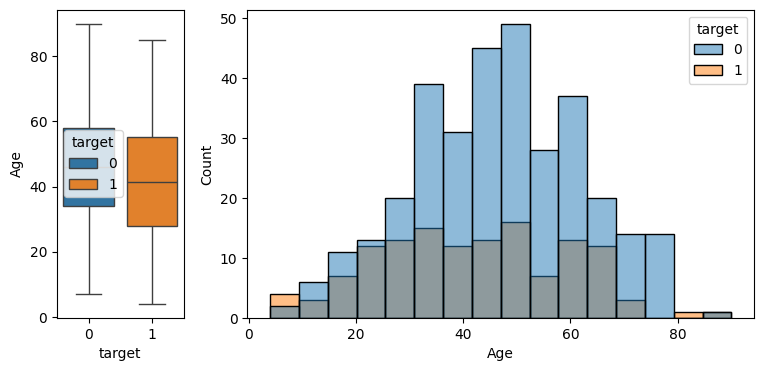

In [142]:
histbox(raw_ILDS, "Age", 16)

### Total Bilirubin

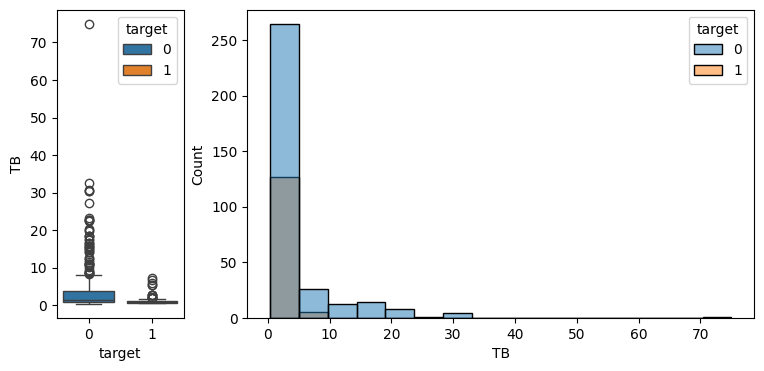

In [143]:
histbox(raw_ILDS, "TB", 16) # TODO2: Una transformació logarítmica potser és millor.

In [144]:
(raw_ILDS.TB==75).value_counts() # TODO: potser no és un missing value, i realment algú el tenia tan alt?

TB
False    461
True       1
Name: count, dtype: int64

Seems like 75 is a _missing_ value, lets delete it

In [145]:
ILDS = raw_ILDS[raw_ILDS.TB!=75]

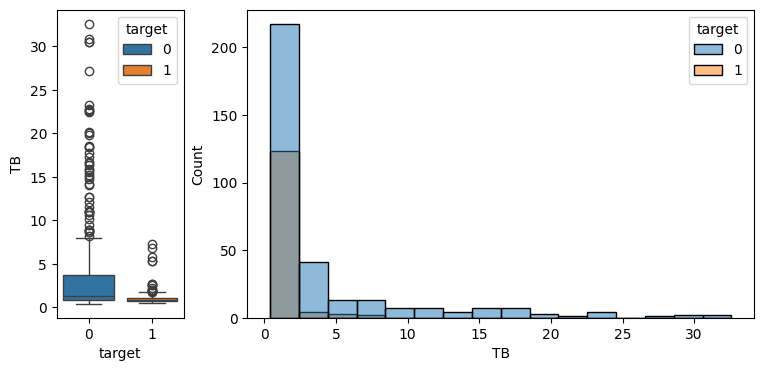

In [146]:
histbox(ILDS, "TB", 16)

C:\Users\haoka\AppData\Local\Temp\ipykernel_13088\259639918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ILDS['log_TB'] = np.log(ILDS['TB'])


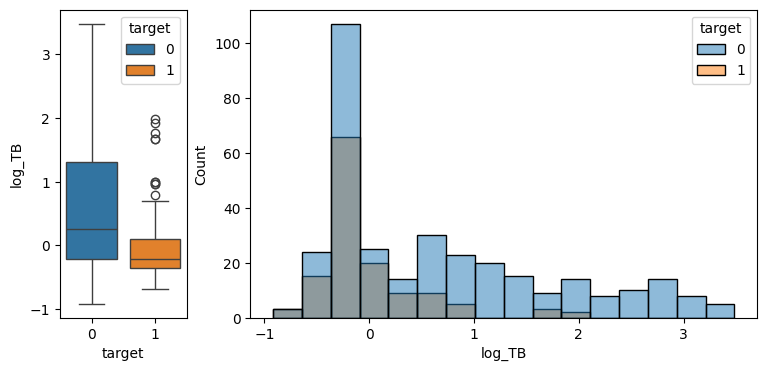

In [147]:
ILDS['log_TB'] = np.log(ILDS['TB'])
histbox(ILDS, "log_TB", 16)

### Direct Bilirubin

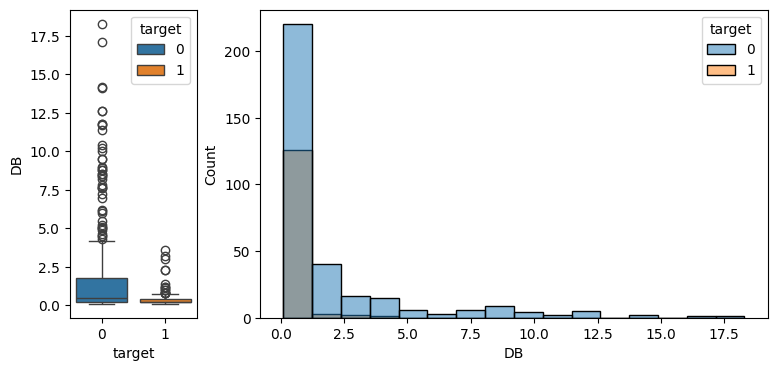

In [ ]:
histbox(raw_ILDS, "DB", 16)

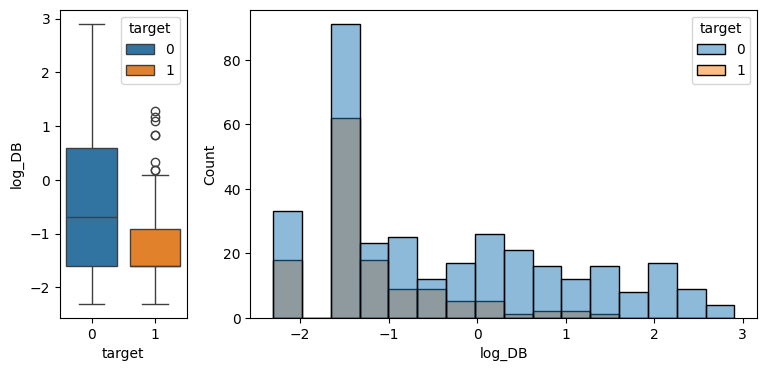

In [ ]:
ILDS['log_DB'] = np.log(raw_ILDS['DB'])
histbox(ILDS, "log_DB", 16)

### Indirect Bilirubin

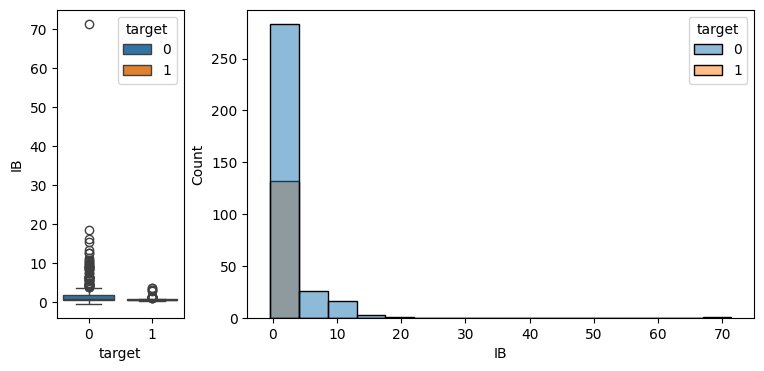

In [150]:
histbox(raw_ILDS, "IB", 16) # TODO: Logarithmic també?

C:\Users\haoka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


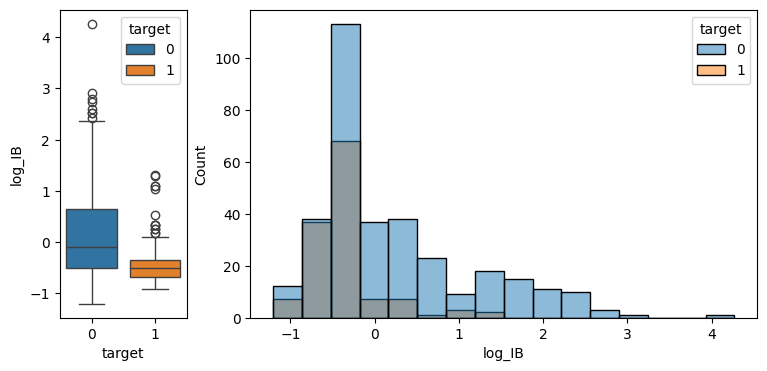

In [ ]:
ILDS['log_IB'] = np.log(raw_ILDS['IB'])
histbox(ILDS, "log_IB", 16)

### Alkaline Phosphotase

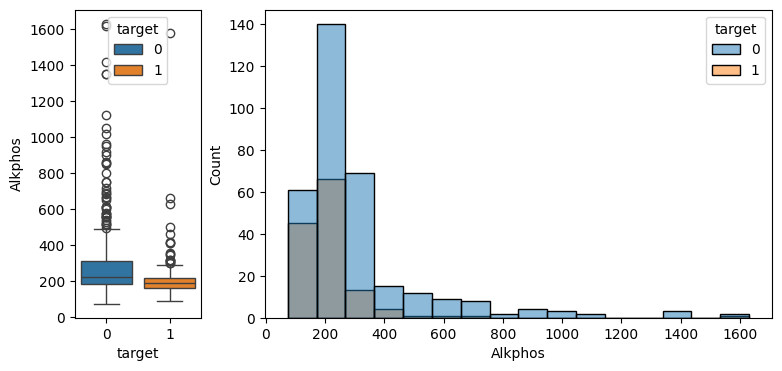

In [152]:
histbox(raw_ILDS, "Alkphos", 16) # TODO: Logarithmic també?

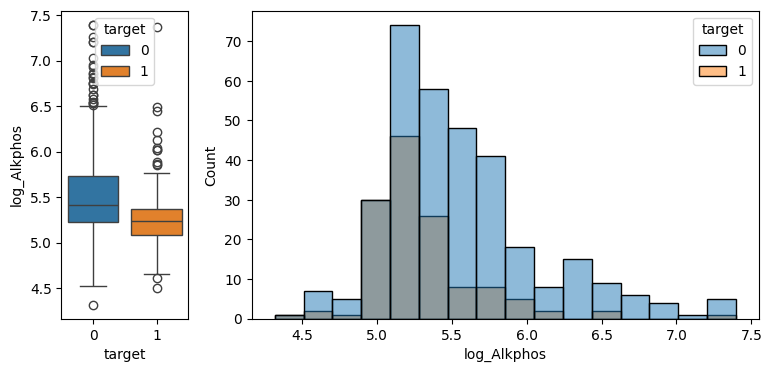

In [ ]:
ILDS['log_Alkphos'] = np.log(raw_ILDS['Alkphos'])
histbox(ILDS, "log_Alkphos", 16)

### Alamine Aminotransferase

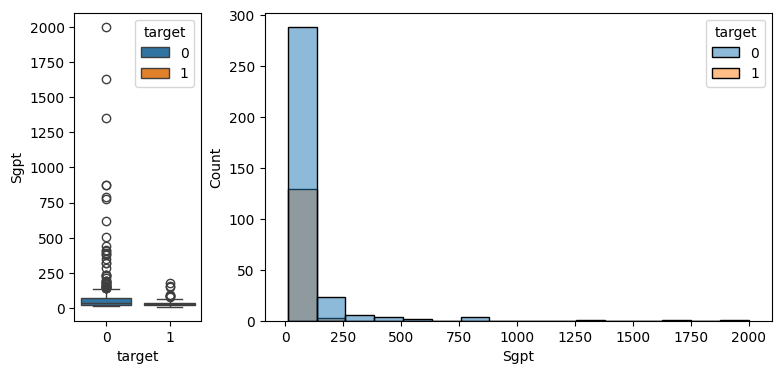

In [154]:
histbox(raw_ILDS, "Sgpt", 16) # TODO: Logarithmic també?

Sgpt==2000 may be a missing value

In [155]:
(raw_ILDS.Sgpt==2000).value_counts()

Sgpt
False    461
True       1
Name: count, dtype: int64

In [156]:
ILDS = ILDS[ILDS.Sgpt != 2000]

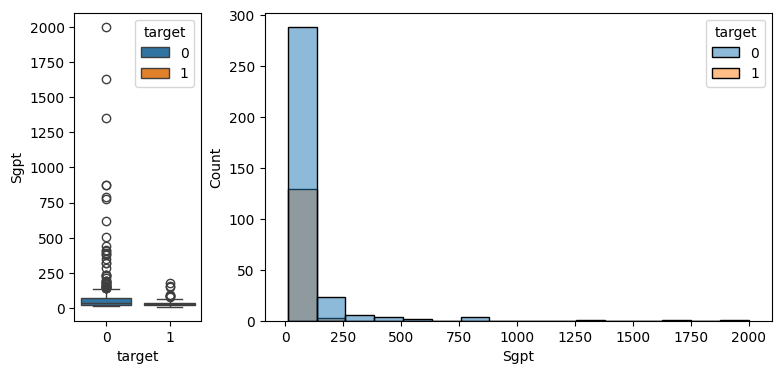

In [157]:
histbox(raw_ILDS, "Sgpt", 16)

### Aspartate Aminotransferase

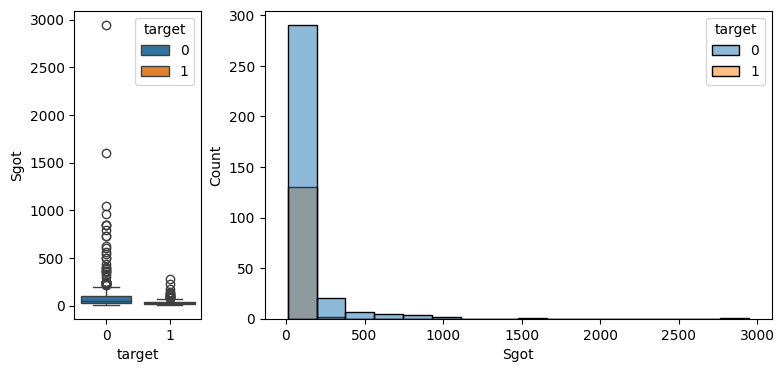

In [158]:
histbox(raw_ILDS, "Sgot", 16) # TODO: Res sembla una normal :D

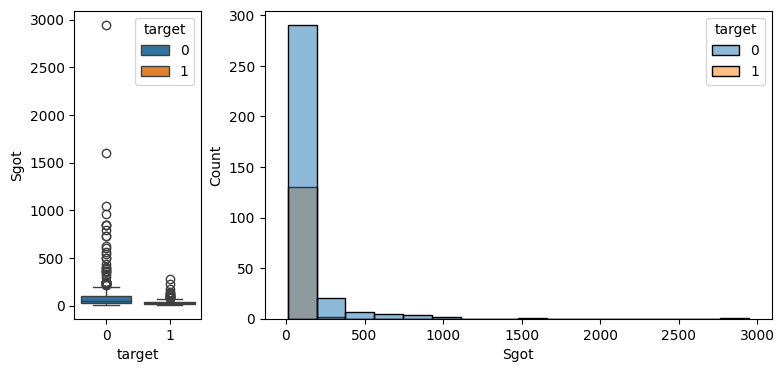

In [161]:
histbox(raw_ILDS, "Sgot", 16)

### Total Protiens

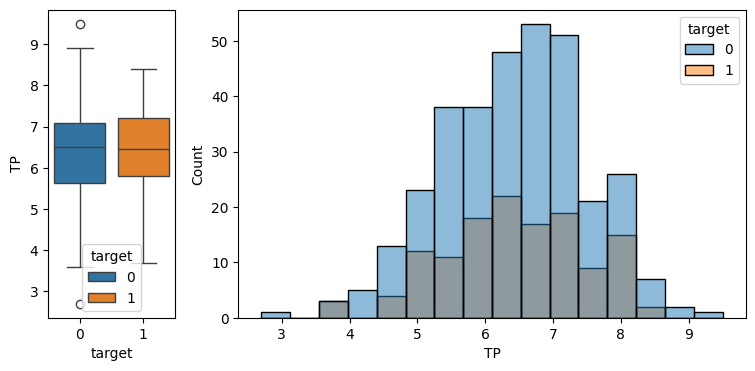

In [162]:
histbox(raw_ILDS, "TP", 16)

### Albumin

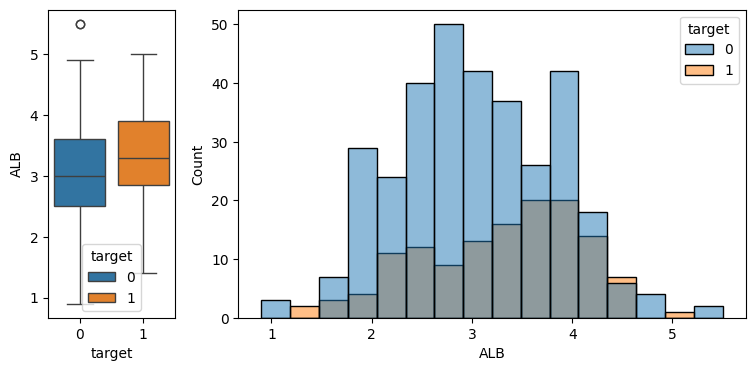

In [163]:
histbox(raw_ILDS, "ALB", 16) # Cool

### Albumin and Globulin Ratio

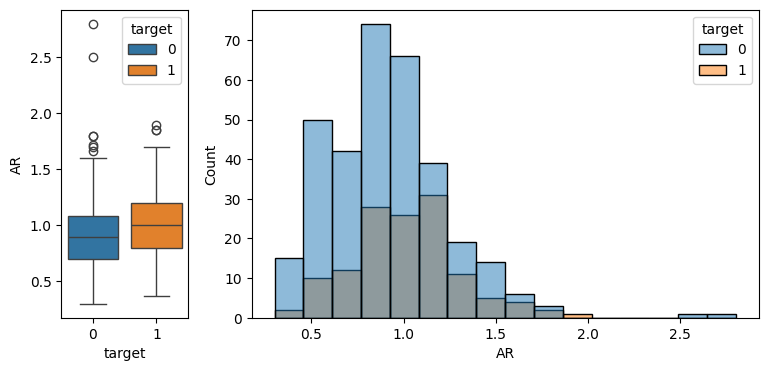

In [164]:
histbox(raw_ILDS, "AR", 16) # TODO: Logarithmic també?